In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [4]:
train_data_path = 'DEEPSAT6/X_train_sat6.csv'
train_label_path = 'DEEPSAT6/y_train_sat6.csv'
test_data_path = 'DEEPSAT6/X_test_sat6.csv'
test_label_path = 'DEEPSAT6/y_test_sat6.csv'

In [5]:
x_train = pd.read_csv(train_data_path, header=None, dtype='uint8')
y_train = pd.read_csv(train_label_path, header=None, dtype='uint8')
x_test = pd.read_csv(test_data_path, header=None, dtype='uint8')
y_test = pd.read_csv(test_label_path, header=None, dtype='uint8')

In [6]:
print("Train data shape: ", x_train.shape)
print("Train label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Train data shape:  (324000, 3136)
Train label shape:  (324000, 6)
Test data shape:  (81000, 3136)
Test label shape:  (81000, 6)


In [7]:
x_train = x_train.values.reshape([-1,28,28,4])
x_test = x_test.values.reshape([-1,28,28,4])

x_train.shape, x_test.shape

((324000, 28, 28, 4), (81000, 28, 28, 4))

In [8]:
class_names = ['Construction', 'Road', 'Grassland', 'Barren', 'Water', 'Treecover']
class_count = len(class_names)

print("Num. classes: %d" % class_count)
print("Class names:", class_names)

Num. classes: 6
Class names: ['Construction', 'Road', 'Grassland', 'Barren', 'Water', 'Treecover']


In [9]:
def label_converter(values):
  if values[0] == 1:    # Building / Construção
    return 0
  elif values[1] == 1:  # Barren land / Solo exposto
    return 3
  elif values[2] == 1:  # Trees / Árvores
    return 5
  elif values[3] == 1:  # Grassland / Pastagem
    return 2
  elif values[4] == 1:  # Road / Estrada
    return 1
  elif values[5] == 1:  # Water / Água
    return 4
  else:
    return None

In [10]:
y_train = y_train.apply(label_converter, axis=1).values.ravel().astype('uint8')
#y_train = train_label.values.ravel().astype('uint8')
#y_train = train_label.apply(label_converter, axis=1).astype('category')
y_train

array([5, 3, 4, ..., 4, 2, 3], dtype=uint8)

In [11]:
y_test = y_test.apply(label_converter, axis=1).values.ravel().astype('uint8')
#y_test = test_label.values.ravel().astype('uint8')
#y_test = test_label.apply(label_converter, axis=1).astype('category')
y_test

array([5, 5, 4, ..., 5, 4, 5], dtype=uint8)

In [12]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([ 3714,  2070, 12596, 18367, 30068, 14185], dtype=int64))

In [13]:
def show_samples(data, labels):
    fig = plt.figure(figsize=(16, 8))
    ax = []
    rows, columns = 4, 8
    
    for i in range(columns * rows):
        index = np.random.randint(1, 500)
        img = data[index].reshape([28,28,4])[:,:,:3]
        class_name = class_names[labels[index]]
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title(class_name)
        plt.axis("off")
        plt.imshow(img)

    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.show()

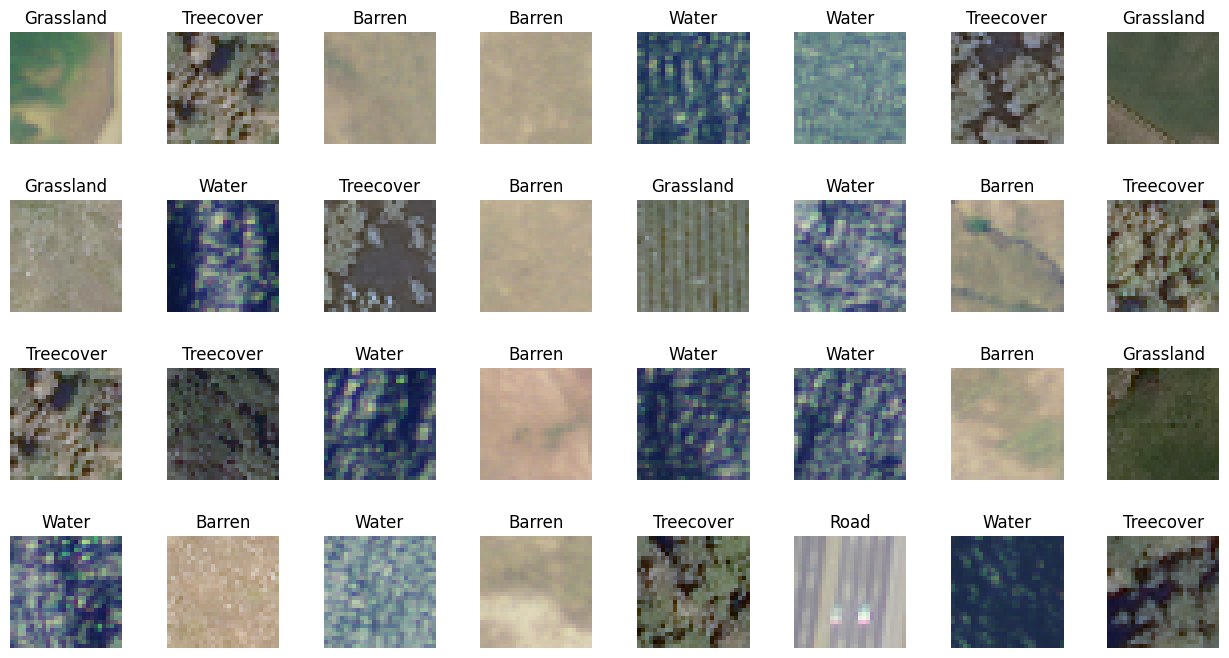

In [14]:
show_samples(x_train, y_train)